[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_indepth.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# MultiMin: In-depth tutorial

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components.

## Likelihood and fitting

We fit by minimizing the **negative normalized log-likelihood**

$$
-\frac{\log \mathcal{L}}{S} = -\frac{1}{S} \sum_{i=1}^{S} \log \mathcal{C}_M(\tilde{U}_i)
$$

over the CMND parameters. Lower values indicate a better fit.

This notebook demonstrates how to use the `multimin.multimin` module for handling multidimensional distributions, specifically designed for asteroid population analysis.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

Welcome to MultiMin v0.6.4


Load the dataset (e.g. orbital elements):

In [3]:
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i"]])
len(data_neas)

40761

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [4]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas)
for i in range(len(data_neas)):
    udata[i]=mn.Util.t_if(data_neas[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

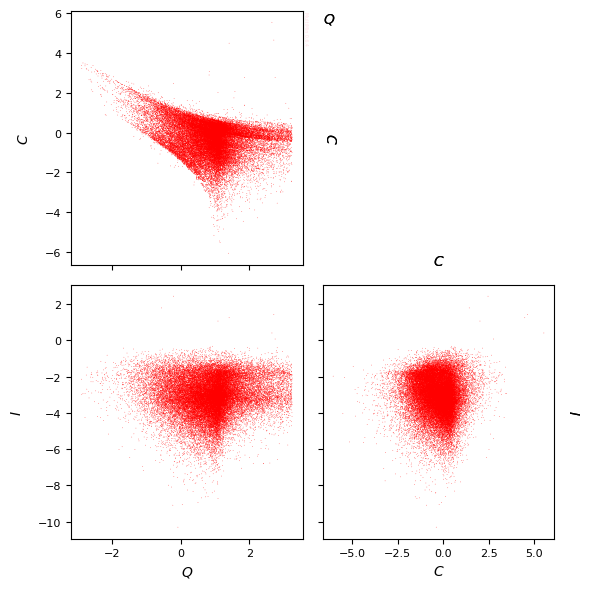

In [5]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


You can also show 2D histograms on the panels:

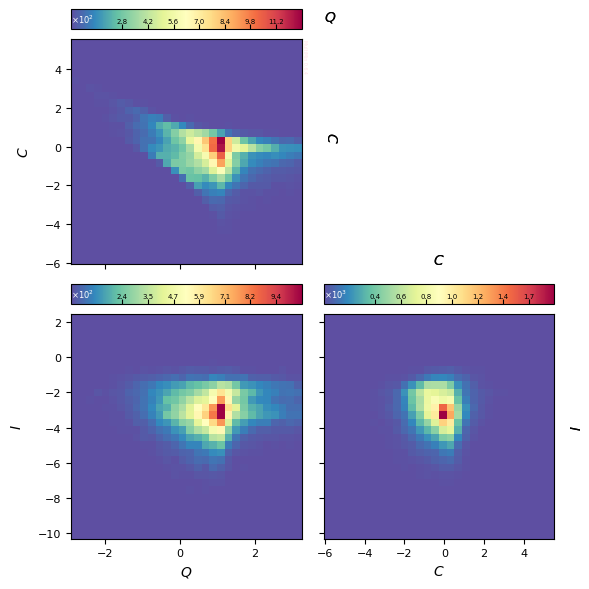

In [6]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create a **Composed Multivariate Normal** (CMND) with one component:

In [7]:
CMND=mn.ComposedMultiVariateNormal(ngauss=1,nvars=2)
print(CMND)

Composition of ngauss = 1 gaussian multivariates of nvars = 2 random variables:
    Weights: [1.0]
    Number of variables: 2
    Averages (μ): [[0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0], [0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (6):
            [p1,μ1_1,μ1_2,Σ1_11,Σ1_12,Σ1_22]
            [1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (6):
            [p1,μ1_1,μ1_2,σ1_1,σ1_2,ρ1_12]
            [1.0, 0.0, 0.0, 1.0, 1.0, 0.0]


Generate a random sample from the CMND:

In [8]:
sample = CMND.rvs(10000)

Plot the sample (2D histograms):

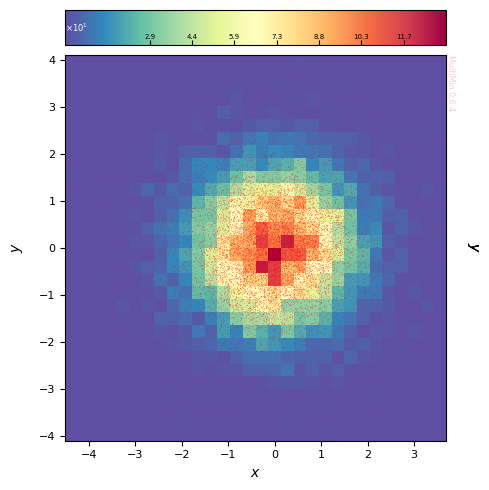

In [9]:
properties=dict(
    x=dict(label=r"$x$",range=None),
    y=dict(label=r"$y$",range=None),
)
G=mn.DensityPlot(properties,figsize=5)

hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(sample,colorbar=True,**hargs)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(sample,**sargs)

plt.savefig('gallery/indepth_2gauss_sample_density.png')


Create a CMND with **multiple** components (e.g. two Gaussians):

You can specify weights, means, and covariance matrices explicitly:

In [10]:
weights=[0.1,0.9]
mus=[[0,0],[5,5]]
Sigmas=[[[1,0.2],[0,1]],[[1,0],[0,1]]]
MND=mn.ComposedMultiVariateNormal(mus=mus,weights=weights,Sigmas=Sigmas)
print(MND)

Composition of ngauss = 2 gaussian multivariates of nvars = 2 random variables:
    Weights: [0.1, 0.9]
    Number of variables: 2
    Averages (μ): [[0.0, 0.0], [5.0, 5.0]]
    Standard deviations (σ): [[1.0, 1.0], [1.0, 1.0]]
    Correlation coefficients (ρ): [[0.2], [0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.2], [0.2, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (12):
            [p1,p2,μ1_1,μ1_2,μ2_1,μ2_2,Σ1_11,Σ1_12,Σ1_22,Σ2_11,Σ2_12,Σ2_22]
            [0.1, 0.9, 0.0, 0.0, 5.0, 5.0, 1.0, 0.2, 1.0, 1.0, 0.0, 1.0]
        With std. and correlations (12):
            [p1,p2,μ1_1,μ1_2,μ2_1,μ2_2,σ1_1,σ1_2,σ2_1,σ2_2,ρ1_12,ρ2_12]
            [0.1, 0.9, 0.0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.0]


Or use a flat parameter list (weights, mus, sigmas, correlations):

In [11]:
params=[0.1, 0.9, 0.0, 0.0, 5.0, 5.0, 1.0, 0.2, 1.0, 1.0, 0.0, 1.0]
MND=mn.ComposedMultiVariateNormal(params=params,nvars=2)
print(MND)

Composition of ngauss = 2 gaussian multivariates of nvars = 2 random variables:
    Weights: [0.1, 0.9]
    Number of variables: 2
    Averages (μ): [[0.0, 0.0], [5.0, 5.0]]
    Standard deviations (σ): [[1.0, 1.0], [1.0, 1.0]]
    Correlation coefficients (ρ): [[0.2], [0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.2], [0.2, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (12):
            [p1,p2,μ1_1,μ1_2,μ2_1,μ2_2,Σ1_11,Σ1_12,Σ1_22,Σ2_11,Σ2_12,Σ2_22]
            [0.1, 0.9, 0.0, 0.0, 5.0, 5.0, 1.0, 0.2, 1.0, 1.0, 0.0, 1.0]
        With std. and correlations (12):
            [p1,p2,μ1_1,μ1_2,μ2_1,μ2_2,σ1_1,σ1_2,σ2_1,σ2_2,ρ1_12,ρ2_12]
            [0.1, 0.9, 0.0, 0.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.0]


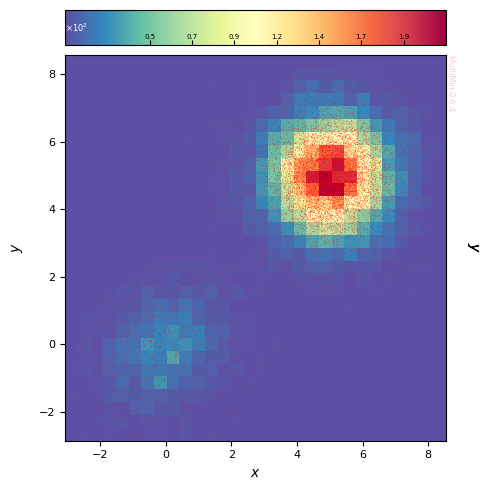

In [12]:
sample = MND.rvs(10000)
properties=dict(
    x=dict(label=r"$x$",range=None),
    y=dict(label=r"$y$",range=None),
)
G=mn.DensityPlot(properties,figsize=5)

hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(sample,colorbar=True,**hargs)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(sample,**sargs)

plt.savefig('gallery/indepth_1gauss_sample_density.png')


## Fitting data to a CMND

We use **FitCMND** to estimate the CMND parameters that maximize the likelihood of the data.

Create the fitter (e.g. one Gaussian, three variables):

In [13]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [14]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [15]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.6, -1.8, 1.4, 1.1, 1.1]
	LogL/N: 5.275128792315277
Iter 1:
	Vars: [1.8, 0.53, -2.5, -1.8, -1.8, -1.9, 1.1, 1, 0.82]
	LogL/N: 4.736038741746765
Iter 2:
	Vars: [0.81, -0.38, -3.1, -2.2, -2.2, -2, -0.037, 0.26, 0.52]
	LogL/N: 4.111534773848801
Iter 3:
	Vars: [0.87, -0.35, -3, -2.4, -2.4, -2.1, -0.63, 0.067, -0.064]
	LogL/N: 3.9703060542433284
Iter 4:
	Vars: [0.87, -0.34, -3.1, -2.4, -2.4, -2.1, -0.64, 0.08, -0.12]
	LogL/N: 3.969228591954478
Iter 5:
	Vars: [0.86, -0.33, -3.1, -2.4, -2.4, -2.1, -0.65, 0.08, -0.12]
	LogL/N: 3.969017364517312
Iter 6:
	Vars: [0.86, -0.33, -3.1, -2.4, -2.4, -2.1, -0.65, 0.08, -0.12]
	LogL/N: 3.969017364517312
Elapsed time since last call: 548.92 ms
-log(L)/N = 3.969017364517312


Inspect the fitted CMND:

In [16]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8595887080250162, -0.32954184396741515, -3.062659235181448]]
    Standard deviations (σ): [[0.855311486752994, 0.8658754811519341, 1.068884804357836]]
    Correlation coefficients (ρ): [[-0.31178340894755485, 0.03990666086892337, -0.06080993182356931]]

    Covariant matrices (Σ): 
        [[[0.7315577393716169, -0.23090468660923588, 0.03648384466474126], [-0.23090468660923588, 0.7497403488600934, -0.05628087768428995], [0.03648384466474126, -0.05628087768428995, 1.1425147249870895]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8595887080250162, -0.32954184396741515, -3.062659235181448, 0.7315577393716169, -0.23090468660923588, 0.03648384466474126, 0.7497403488600934, -0.05628087768428995, 1.1425147249870895]
        With std. and corre

Plot the fit result (fitted sample + data scatter):

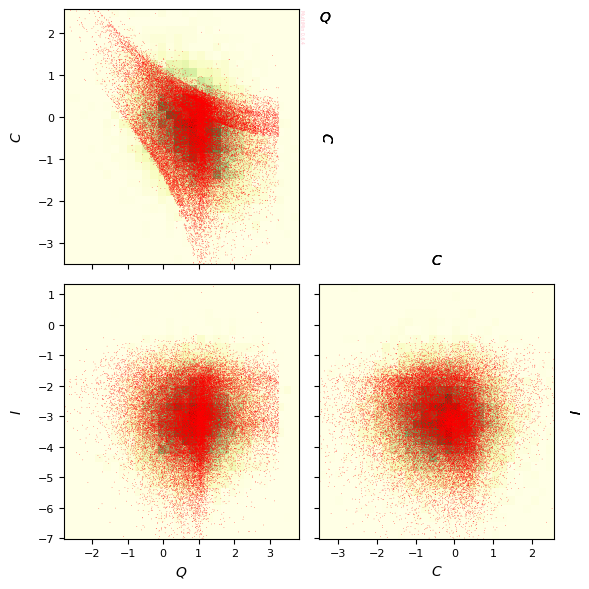

In [17]:
props=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig('gallery/indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [18]:
F.save_fit(f"gallery/fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [19]:
F=mn.FitCMND(f"gallery/fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8595887080250162, -0.32954184396741515, -3.062659235181448]]
    Standard deviations (σ): [[0.855311486752994, 0.8658754811519341, 1.068884804357836]]
    Correlation coefficients (ρ): [[-0.31178340894755485, 0.03990666086892337, -0.06080993182356931]]

    Covariant matrices (Σ): 
        [[[0.7315577393716169, -0.23090468660923588, 0.03648384466474126], [-0.23090468660923588, 0.7497403488600934, -0.05628087768428995], [0.03648384466474126, -0.05628087768428995, 1.1425147249870895]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8595887080250162, -0.32954184396741515, -3.062659235181448, 0.7315577393716169, -0.23090468660923588, 0.03648384466474126, 0.7497403488600934, -0.05628087768428995, 1.1425147249870895]
        With std. and corre

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.51, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.1, 1.3, 1.3, 0.88]
	LogL/N: 4.9458505219980315
Iter 5:
	Vars: [-1.3, -0.016, 0.26, 0.33, -3.3, 1.1, -0.59, -3, -2.4, -2.7, -2, -2.5, -2.4, -2.2, -1.5, -0.66, 0.36, 0.11, 0.29, -0.11]
	LogL/N: 3.8891251452132827
Iter 10:
	Vars: [-1.5, 0.047, 0.45, 0.46, -3.5, 1, -0.6, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.2, -0.67, 0.64, -0.056, 0.23, 0.011]
	LogL/N: 3.881493102618548
Elapsed time since last call: 3.14112 s
-log(L)/N = 3.881493102618548
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2700120847700772, 0.7299879152299228]
    Number of variables: 3
    Averages (μ): [[0.44725207791070887, 0.4563537373055356, -3.468793532199191], [0.9951659495331887, -0.6038880831019894, -2.919110368699787]]
    Standard deviations (σ): [[0.866495207789035, 0.5669171678649431, 1.1777369753205023], [0.8039047467907942, 0.777912722773518, 0.984

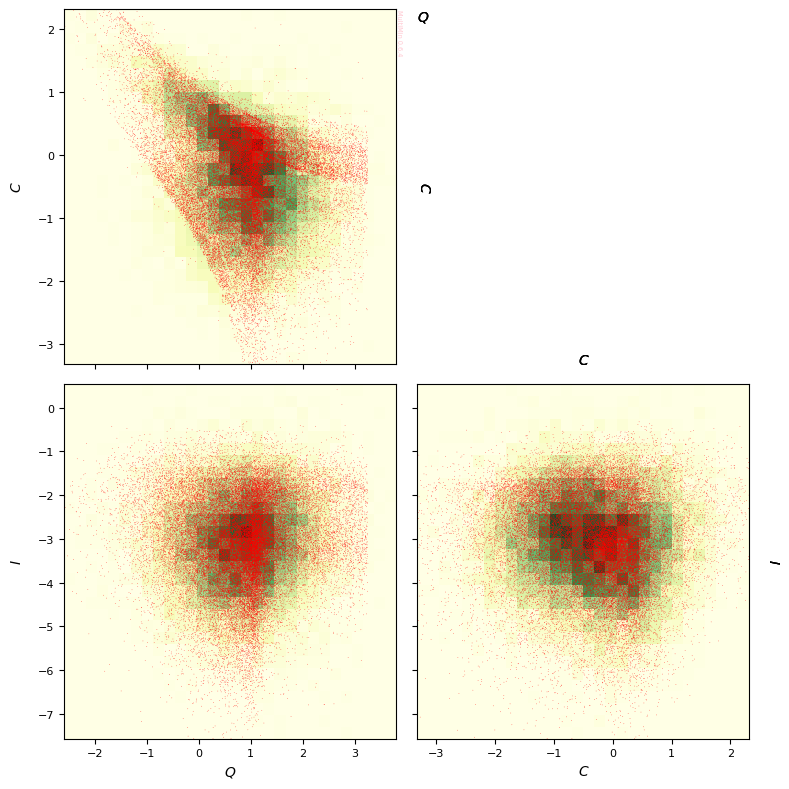

In [20]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.51, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.1, 1.3, 1.3, 0.88]
	LogL/N: 4.946988072199566
Iter 5:
	Vars: [-0.51, 2.2, 0.26, 0.33, -3.3, 1.1, -0.59, -3, -2.4, -2.7, -2, -2.5, -2.4, -2.2, -1.5, -0.66, 0.36, 0.11, 0.29, -0.11]
	LogL/N: 3.8891320562580263
Iter 9:
	Vars: [-0.57, 2.2, 0.44, 0.44, -3.5, 1, -0.62, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.2, -2.1, -0.69, 0.64, -0.025, 0.23, 0.028]
	LogL/N: 3.881816832642783
Elapsed time since last call: 3.14369 s
-log(L)/N = 3.881816832642783
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.28652962897405576, 0.7134703710259441]
    Number of variables: 3
    Averages (μ): [[0.4397622247076394, 0.4395690409678001, -3.4701927823494683], [1.0067249428295835, -0.6165446013871817, -2.90836230710841]]
    Standard deviations (σ): [[0.8607033819910656, 0.5688857715786315, 1.181372093216299], [0.8016845321683012, 0.777159805566266, 0.978

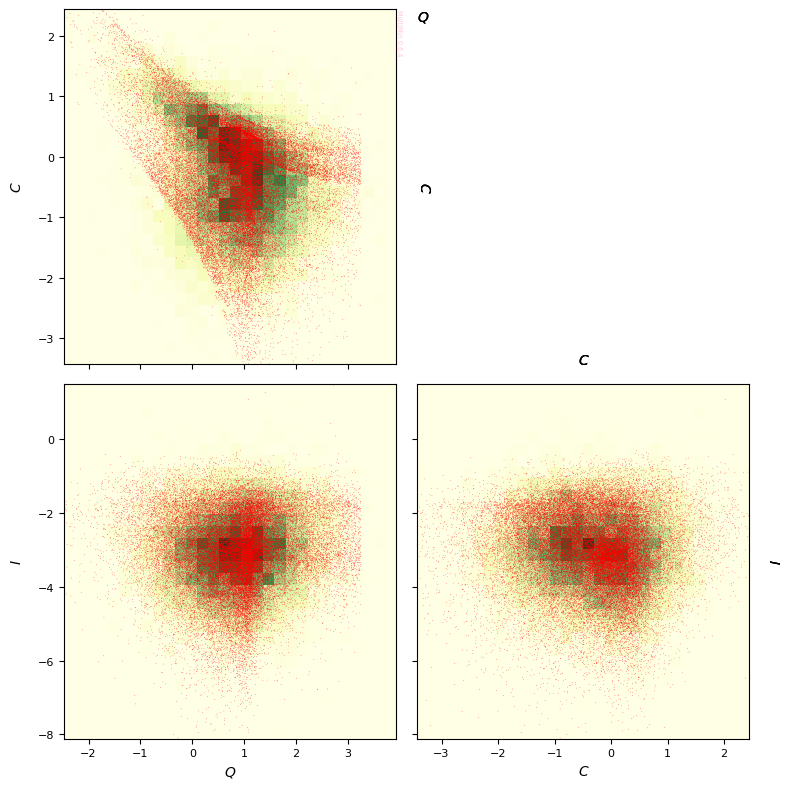

In [21]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.4, -2.2, 2.7, -0.041, -2.2, 1.9, 0.25, -2.9, 1.7, 0.32, -2.3, 0.34, 2, -2.1, -1.3, -1.2, -1.3, -1.4, -2.2, -2.4, -2.1, -3.1, -2, -2.3, -2, -2.1, -2.3, -1.3, -2, 2.3, 1.9, 1.2, 2.2, 1.3, 0.75, 0.11, 1.3, 0.81, 1.6, 1.4, 1.1, 0.66, 0.53, 1.2]
	LogL/N: 4.710396740347264
Iter 10:
	Vars: [-1.7, 1.3, 0.61, -0.065, 0.12, 1.3, -1.2, -4.2, 0.98, -0.75, -2.8, 0.84, 0.35, -3.4, 1.6, -0.2, -3.3, -0.15, -0.28, -2.6, -2.5, -2.2, -1.6, -3.2, -2.7, -2.4, -2.7, -3.3, -2.2, -2.3, -3.2, -2.2, -2.6, -2, -2.4, -0.53, 1.7, -0.76, -0.47, 0.66, -0.13, -1.9, 0.21, 0.071, 0.0076, 0.95, 0.11, -2.4, -0.036, 0.22]
	LogL/N: 3.738039840242975
Iter 19:
	Vars: [-0.88, 0.73, -0.6, -0.24, 0.33, 1.4, -0.78, -3.6, 1, -0.59, -2.8, 0.63, 0.48, -3.6, 1.5, 0.087, -3.1, 0.04, -0.59, -2.7, -2.5, -2.6, -1.8, -3.3, -2.8, -2.3, -2.7, -3.2, -2, -2.4, -3.6, -2.5, -2.5, -2, -2.3, -0.31, 1.6, -0.18, -0.69, 0.57, -0.48, -2.4, -0.2, 0.36, -1, 0.39, 0.4, -2.5, -0.18, 0.39]
	LogL

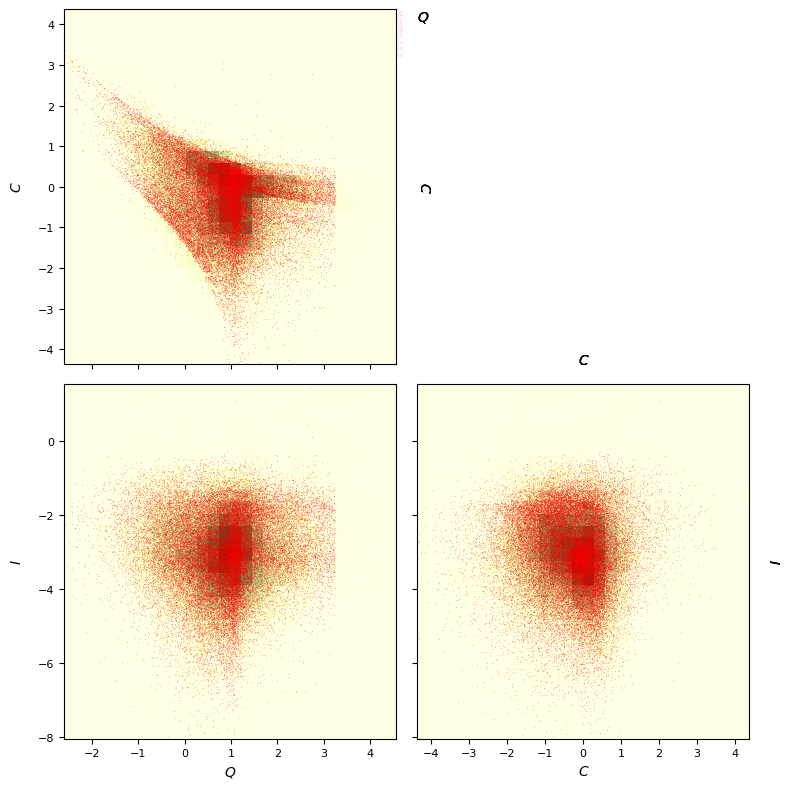

In [22]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

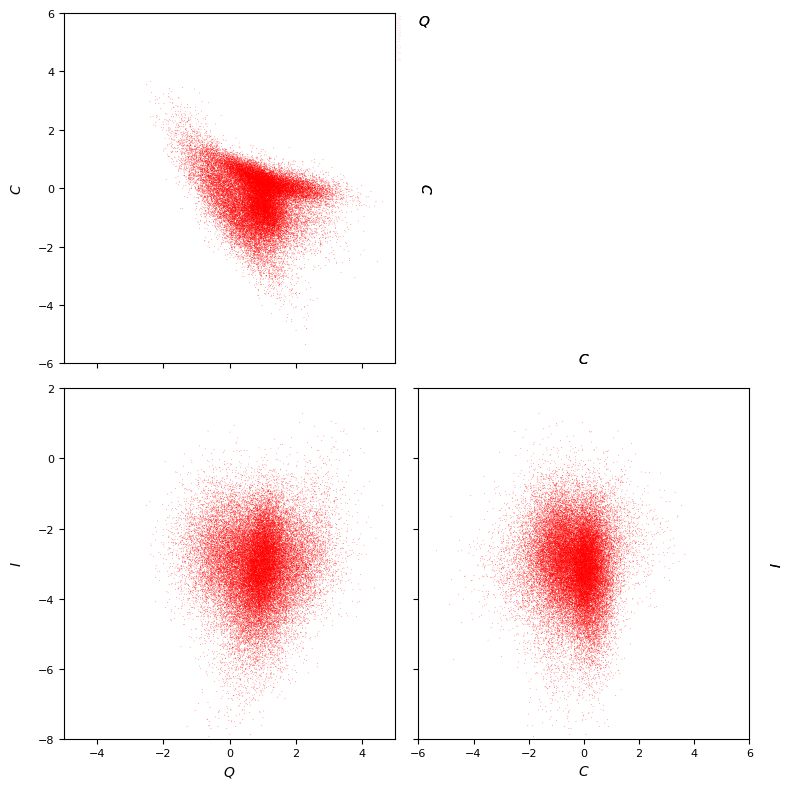

In [23]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=4,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/sample-multiple-{F.prefix}.png")

Compare with the original data distribution:

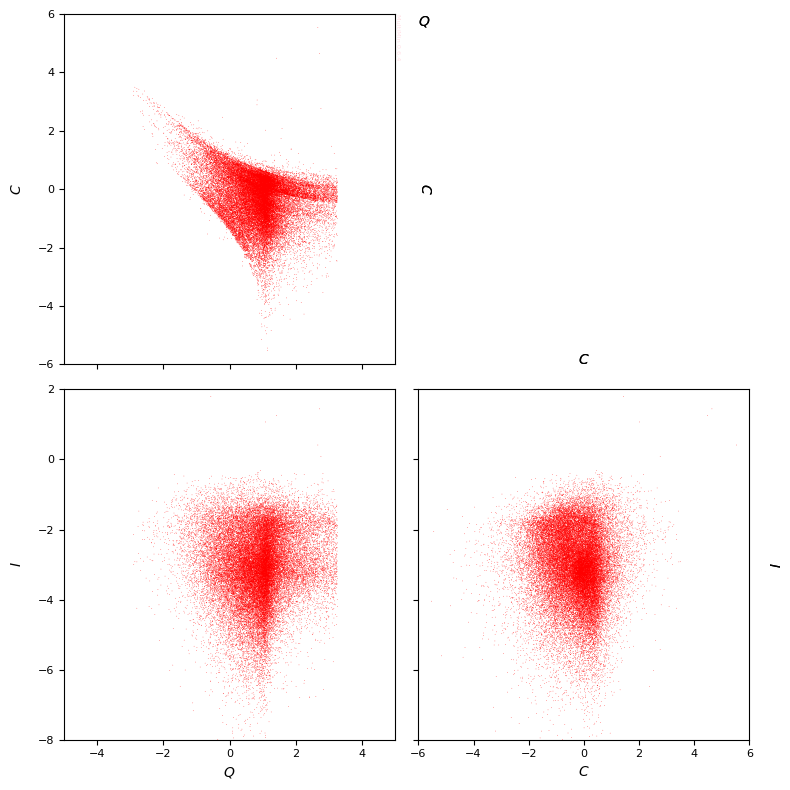

In [24]:
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=4)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)
G.fig.savefig("gallery/indepth_true_MPC_sample_QCI.png")

Fitting with 20 components can approximate the distribution very closely:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 3.1, 1.6, -2.3, 2.9, -0.11, -2.3, 2.4, -0.25, -2.8, 2.4, -0.38, -2.4, 2.2, -0.44, -3.7, 2.2, -0.43, -2.2, 2, 3, -2.1, 2, -0.38, -2.6, 1.9, -0.46, -2.6, 1.8, -0.47, -4.2, 1.8, -0.21, -2.5, 1.7, 3, -1.7, 1.7, 0.54, -3, 1.6, 0.45, -2.6, 1.6, 0.2, -2.3, 1.5, 2.8, -1.5, 1.4, 1.3, -3.8, 1.2, 1.8, -1.7, 1.2, 1, -2.1, 0.84, 1.1, -1.7, -0.45, -1.1, -2.4, -1.1, -3.5, -2.3, -1.5, -3.2, -2.4, -1.6, -2.4, -2.5, -1.8, -2.9, -1.6, -1.9, -1.8, -2.7, -0.93, -0.58, -2.1, -2.1, -2.6, -2.2, -2.2, -2.3, -2.2, -2.2, -2.5, -2.3, -2.3, -2.2, -2.2, -1.1, -0.51, -3.8, -2.3, -3.5, -1.9, -2.4, -3.5, -2.2, -2.5, -3.8, -1.9, -1.3, -0.64, -3.1, -1.9, -2.3, -2.1, -1.7, -1.2, -2.2, -2.1, -1.7, -2.2, -2.2, -2, -2, 2.6, 2.3, 1.1, 2.2, 1.6, 0.65, 2.2, 1.8, 0.85, 2.6, 1.4, 0.63, 0.45, 0.41, -0.97, 1.9, 1.2, 0.82, 1.7, 1.9, 2.1, 2, 1.3, 0.45, 1.1, 1.3, 0.32, 0.86, 0.88, 0.72, 1.4, 1.2, 0.79, 2.2, 1.

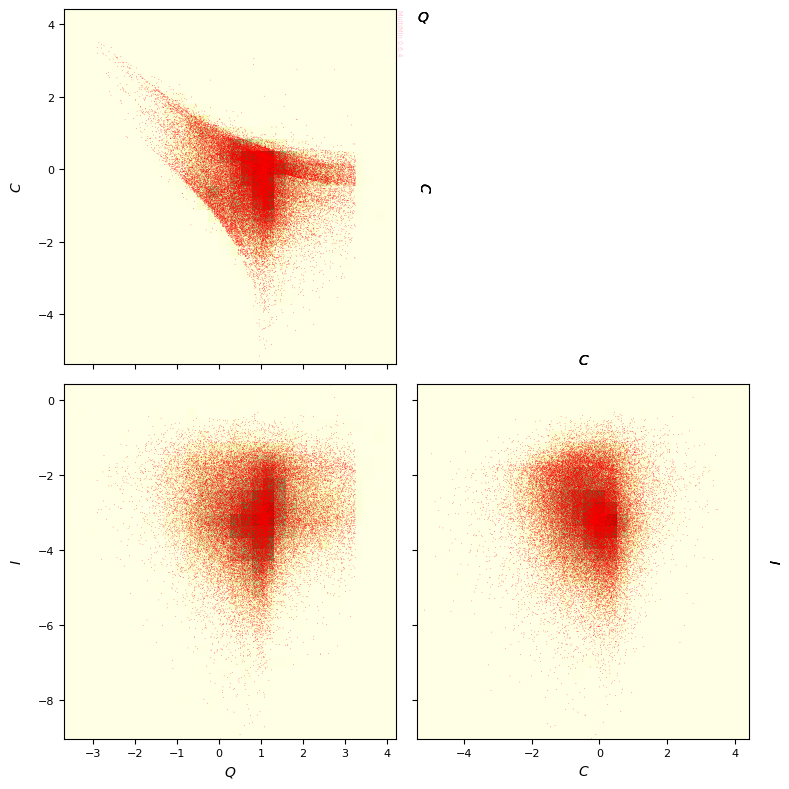

In [25]:
F=mn.FitCMND(ngauss=20,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=True)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_20gauss_bound_mus_QCI.png")

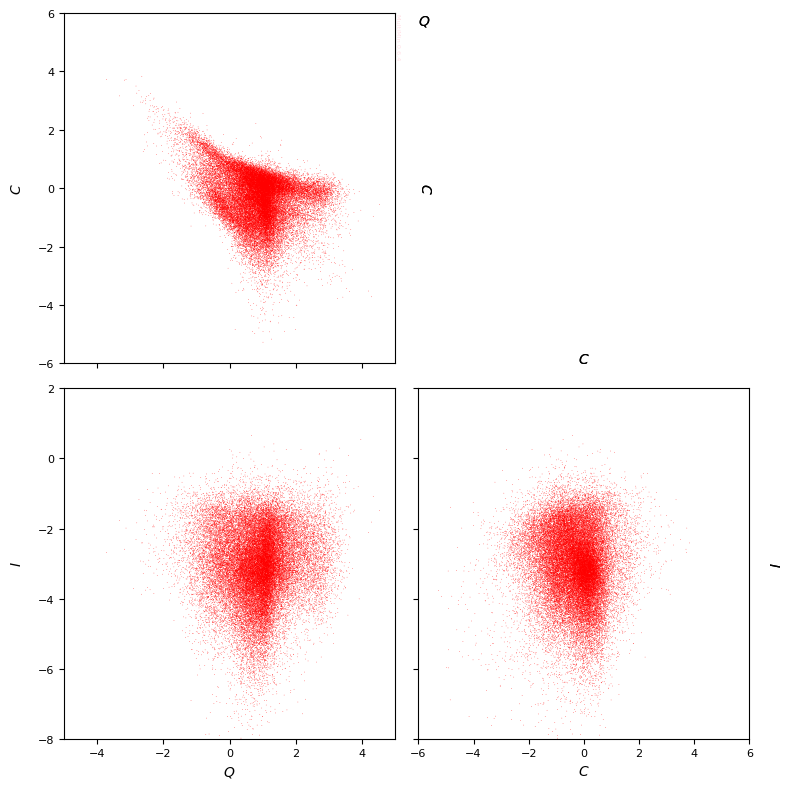

In [26]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=4,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig("gallery/indepth_sample_from_fit_20gauss_QCI.png")

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga